## Luggage Bag Cost Prediction

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Load the dataset

In [100]:
dataset = 'Miniproject_Dataset.xlsx'
# Load the dataset
df = pd.read_excel(dataset)
# Check the data types
print(df.dtypes)
# Display first 5 rows
df.head()

Cost       float64
Weight      object
Weight1    float64
Length      object
Height     float64
Width       object
dtype: object


,Cost,Weight,Weight1,Length,Height,Width
0,242.0,23.2,25.4,30,11.5200,4.02
1,290.0,24,26.3,31.2,12.4800,4.3056
2,340.0,23.9,26.5,31.1,12.3778,4.6961
3,363.0,26.3,29.0,33.5,12.7300,4.4555
4,430.0,26.5,29.0,34,12.4440,5.134


### Exploratory Data Analysis (EDA)

#### Standardize data formats

In [101]:
# Find columns with object type
object_cols = df.select_dtypes(include=['object']).columns
if not object_cols.empty:
    # Convert object columns to numeric
    df[object_cols] = df[object_cols].apply(pd.to_numeric, errors='coerce')
    print("Inconsistent columns", ', '.join(object_cols), "were converted to numeric.")

df.describe()

Inconsistent columns Weight, Length, Width were converted to numeric.


,Cost,Weight,Weight1,Length,Height,Width
count,159.000000,157.000000,159.000000,158.000000,158.000000,157.000000
mean,398.326415,26.259873,28.415723,31.239241,8.933124,3826.050502
std,357.978317,10.052942,10.716328,11.646141,4.273069,47884.860134
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.000000,21.000000,23.125000,5.940600,3.395700
50%,273.000000,25.200000,27.300000,29.700000,7.733000,4.248500
75%,650.000000,32.700000,35.500000,39.675000,12.248700,5.589000
max,1650.000000,59.000000,63.400000,68.000000,18.957000,600000.000000


#### Handle missing values

In [102]:
# Find columns with missing values
missing_value_cols = df.columns[df.isnull().sum() > 0]

if not missing_value_cols.empty:
    # Fill missing values using mean()
    df.fillna({col: df[col].mean() for col in missing_value_cols}, inplace=True)
    print("Missing values in columns", ', '.join(missing_value_cols), "were filled with their respective mean values.")

# Summary statistics
df.describe()

Missing values in columns Weight, Length, Height, Width were filled with their respective mean values.


,Cost,Weight,Weight1,Length,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.259873,28.415723,31.239241,8.933124,3826.050502
std,357.978317,9.989113,10.716328,11.609227,4.259525,47580.826202
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.401600
50%,273.000000,25.400000,27.300000,30.000000,7.786000,4.305600
75%,650.000000,32.700000,35.500000,39.650000,12.143400,5.789550
max,1650.000000,59.000000,63.400000,68.000000,18.957000,600000.000000


#### Boxplot before outlier capping

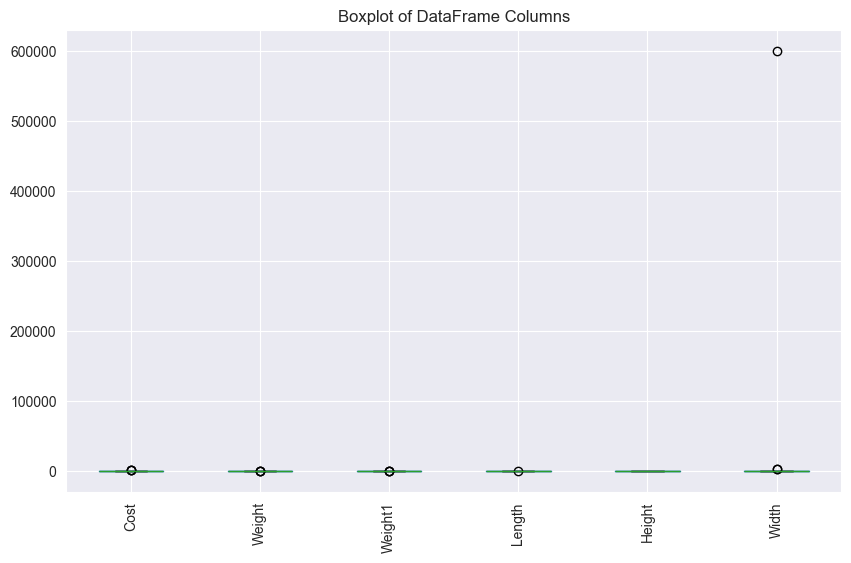

In [103]:
# Draw the boxplot
df.boxplot(column=df.columns.tolist(), figsize=(10, 6))
plt.title('Boxplot of DataFrame Columns')
plt.xticks(rotation=90)
plt.show()

#### Outlier Capping using the Interquartile Range (IQR) method
__Note:__ Outlier is present only for Width column and is capped to the upper bound. However for the purpose of this project, we will perform capping the outliers for all columns.

In [104]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Determine the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap the outliers to the lower and upper bounds
df = df.clip(lower=lower_bound, upper=upper_bound, axis=1)

df.describe()

,Cost,Weight,Weight1,Length,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,395.401887,26.187703,28.342453,31.216599,8.933124,4.515995
std,348.555952,9.775064,10.499859,11.540385,4.259525,1.794227
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.401600
50%,273.000000,25.400000,27.300000,30.000000,7.786000,4.305600
75%,650.000000,32.700000,35.500000,39.650000,12.143400,5.789550
max,1445.000000,53.175000,57.250000,64.400000,18.957000,9.371475


#### Boxplot after outlier capping

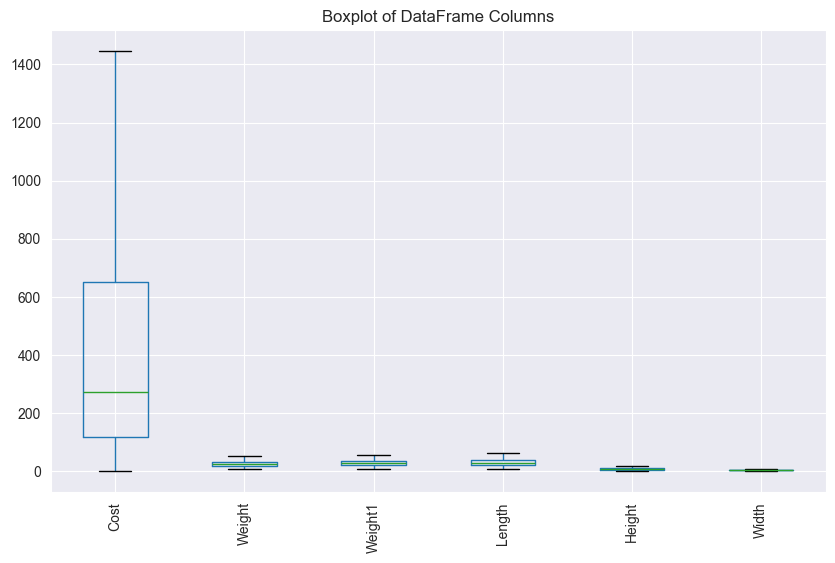

In [105]:
# Draw the boxplot
df.boxplot(column=df.columns.tolist(), figsize=(10, 6))
plt.title('Boxplot of DataFrame Columns')
plt.xticks(rotation=90)
plt.show()

#### Correlation Heatmap

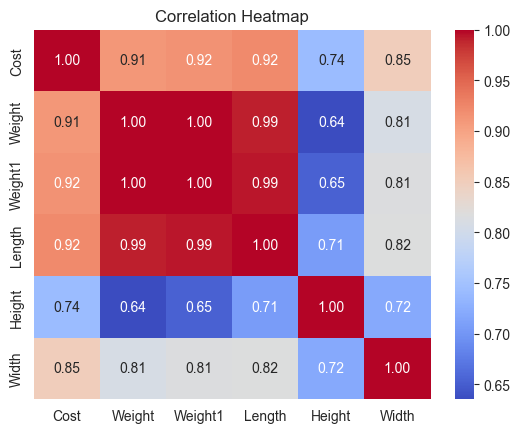

In [106]:
dataplot = sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm',fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

#### Define feature and target variables

In [107]:
# Define the features and target variable
X = df.drop(columns=['Cost']) # We can also drop 'Height' and 'Width' columns as they are weakly correlated with 'Cost'
y = df['Cost']

#### Regression Plots

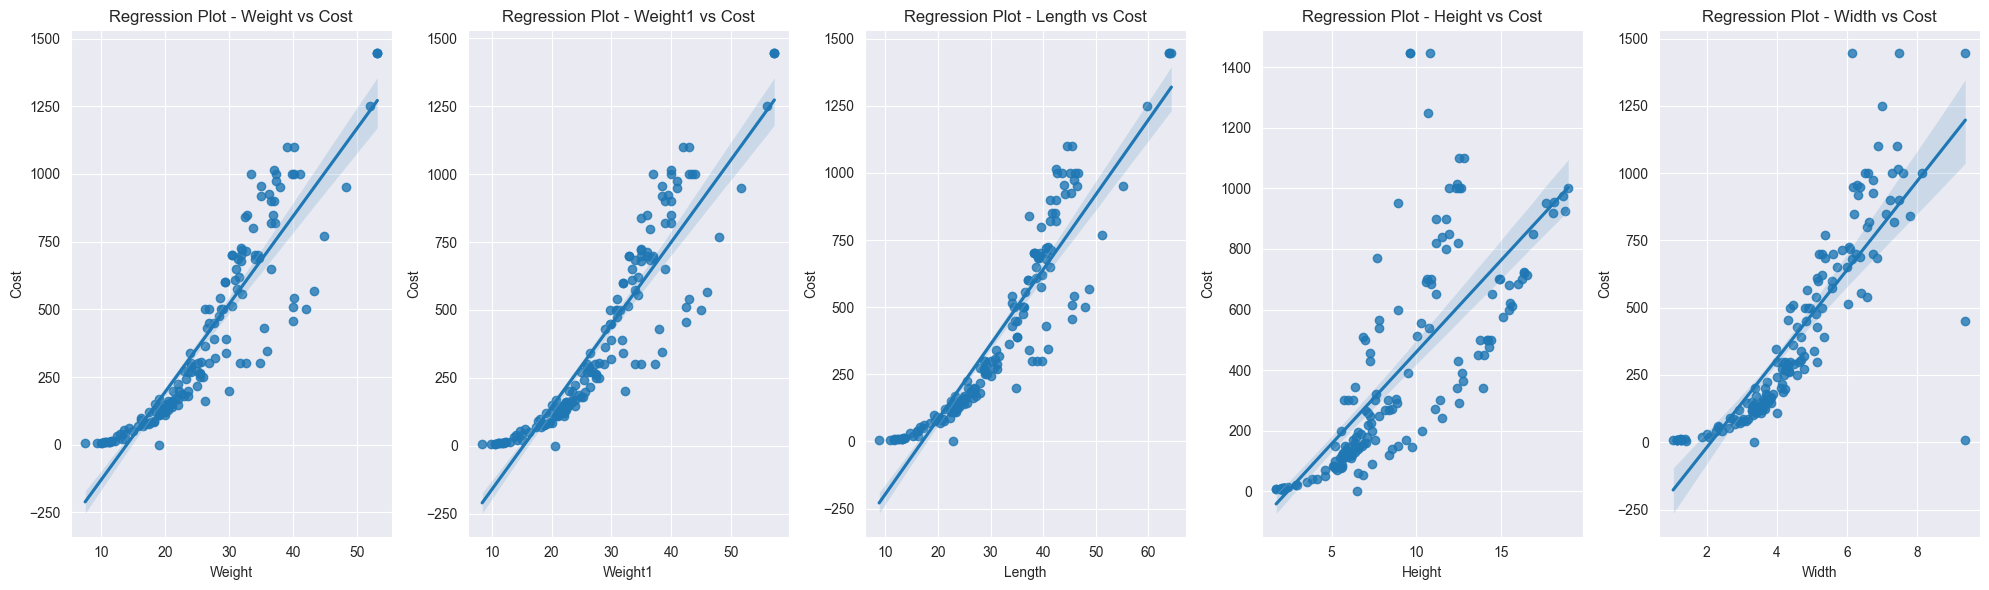

In [108]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(X.columns), figsize=(20, 6))

# Draw regression plots for each feature against the target variable
for ax, feature in zip(axes, X.columns):
    sns.regplot(x=df[feature], y=y, ax=ax)
    ax.set_title(f'Regression Plot - {feature} vs Cost')
    ax.set_xlabel(feature)
    ax.set_ylabel('Cost')

# Adjust layout
plt.tight_layout()
plt.show()

#### Residual Plots

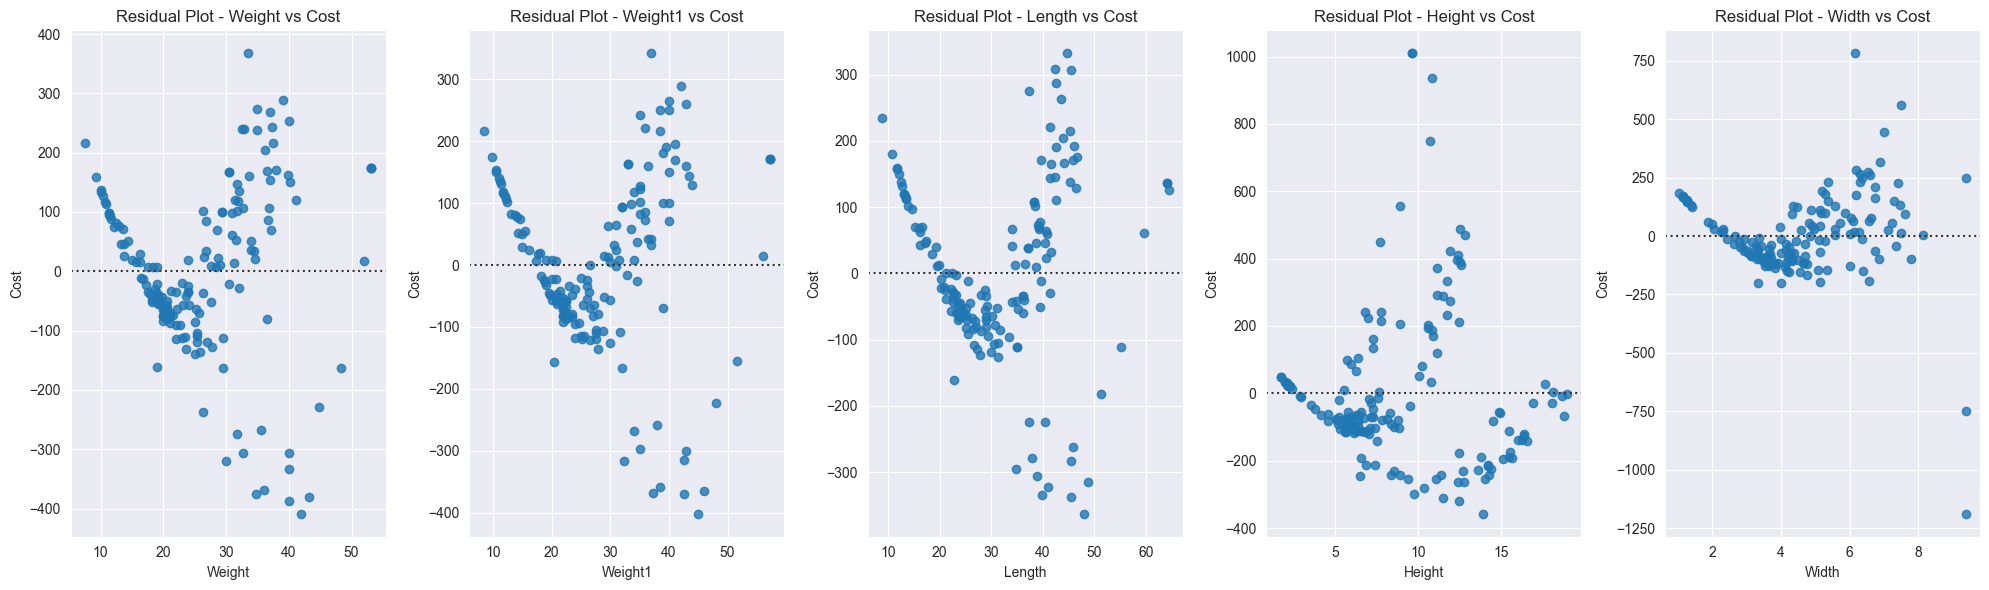

In [109]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(X.columns), figsize=(20, 6))

# Draw regression plots for each feature against the target variable
for ax, feature in zip(axes, X.columns):
    sns.residplot(x=df[feature], y=y, ax=ax)
    ax.set_title(f'Residual Plot - {feature} vs Cost')
    ax.set_xlabel(feature)
    ax.set_ylabel('Cost')

# Adjust layout
plt.tight_layout()
plt.show()

#### Split the dataset into training and testing sets

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def print_summary(y_pred):
    print("R-squared", r2_score(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error (MSE)", mse)
    print("Root Mean Squared Error (RMSE)", np.sqrt(mse))

def plot_comparison(y_pred):
    # Plot y_test and y_pred for comparison
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='dashed')
    plt.xlabel('Sample Index')
    plt.ylabel('Cost')
    plt.title('Comparison of Actual and Predicted Values')
    plt.legend()
    plt.show()

#### Build model using normal Linear Regression

Coefficient: [-1.9531567  16.19649282  6.57020957 10.86419092 43.78484623]
Intercept: -523.3103087141214
R-squared 0.873887893447888
Mean Squared Error (MSE) 17938.096097350175
Root Mean Squared Error (RMSE) 133.93317773184572


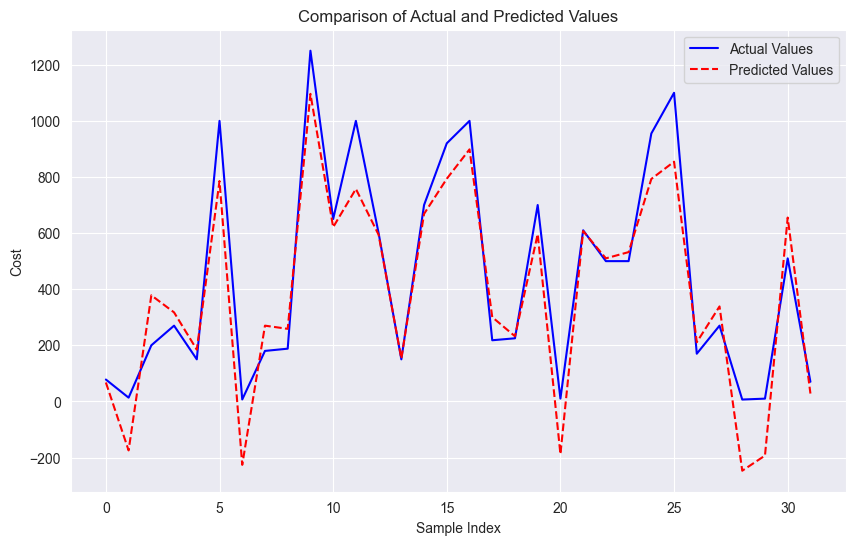

In [111]:
# Initialize the Linear Regression model
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

y_pred_lr = linear_regression.predict(X_test)

print("Coefficient:", linear_regression.coef_)
print("Intercept:", linear_regression.intercept_)

print_summary(y_pred_lr)
plot_comparison(y_pred_lr)

## Build a model using Gradient Descent

Coefficient: [4.44553316 4.33335852 6.17180133 2.92623587 2.60481934]
Intercept: [-6.24622514]
R-squared 0.6667141744865188
Mean Squared Error (MSE) 47406.338133564255
Root Mean Squared Error (RMSE) 217.7299660900269


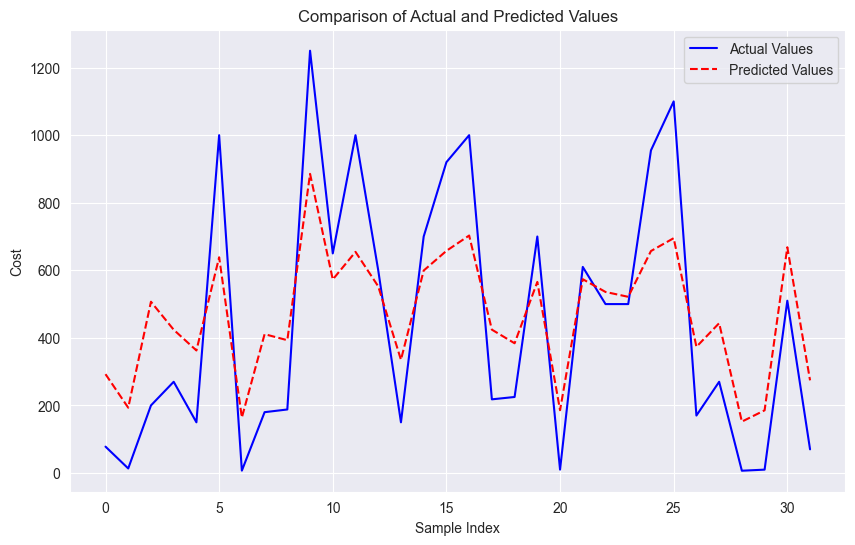

In [112]:
# Initialize the SGD Regressor
gd_regressor = SGDRegressor(eta0 = 1e-4, learning_rate= "constant", max_iter = 1000, tol = 1e-3, random_state = 42)

# Fit the model to the training data
gd_regressor.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred_gd = gd_regressor.predict(X_test)

# Print the coefficients and intercept
print("Coefficient:", gd_regressor.coef_)
print("Intercept:", gd_regressor.intercept_)

print_summary(y_pred_gd)
plot_comparison(y_pred_gd)

#### Build model using Stochastic Gradient Descent (SGD) Regressor

Coefficient: [4.4572025  4.76026416 5.45463166 2.1056275  1.241104  ]
Intercept: [-1.31053494]
R-squared 0.6442016758537215
Mean Squared Error (MSE) 50608.49988398838
Root Mean Squared Error (RMSE) 224.9633300873464


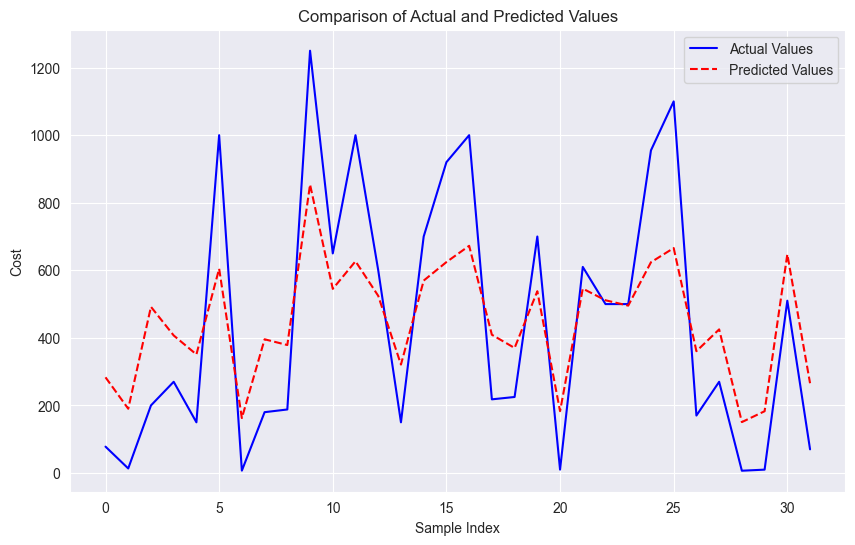

In [113]:
# Initialize the SGD Regressor
sgd_regressor = SGDRegressor(eta0 = 1e-4, max_iter = 1000, tol = 1e-3, random_state = 42)

# Fit the model to the training data
sgd_regressor.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred_sgd = sgd_regressor.predict(X_test)

# Print the coefficients and intercept
print("Coefficient:", sgd_regressor.coef_)
print("Intercept:", sgd_regressor.intercept_)

print_summary(y_pred_sgd)
plot_comparison(y_pred_sgd)

#### Build model using Mini-Batch Gradient Descent (MBGD) Regressor

Coefficient: [ 4.72571875  1.65755666  7.42816427  4.84661942 11.23212501]
Intercept: [-48.51318626]
R-squared 0.7068839078331964
Mean Squared Error (MSE) 41692.62390994307
Root Mean Squared Error (RMSE) 204.18771733369044


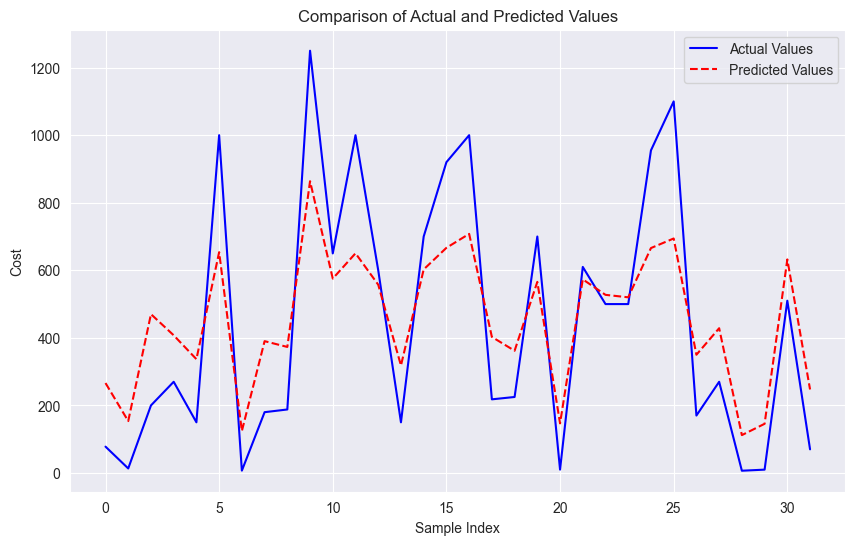

In [114]:
# Initialize the SGD Regressor with Mini-Batch Gradient Descent settings
mbgd_regressor = SGDRegressor(eta0=1e-4, learning_rate="invscaling", max_iter=1000, tol=1e-3, random_state=42)

# Simulate mini-batch gradient descent
n_epochs = 1000
batch_size = 32

for epoch in range(n_epochs):
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        mbgd_regressor.partial_fit(X_batch, y_batch)

# Predict the target variable for the test data
y_pred_mbgd = mbgd_regressor.predict(X_test)

# Print the coefficients and intercept
print("Coefficient:", mbgd_regressor.coef_)
print("Intercept:", mbgd_regressor.intercept_)

print_summary(y_pred_mbgd)
plot_comparison(y_pred_mbgd)
